### **라이브러리 불러오기**

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('final.csv', encoding = 'ANSI')

In [4]:
df.head()

,시도,시군구,행정번호,년도,우울증환자수,평균연령,총인구수,스트레스인지율,고용률,코로나확진자수,1인당 정신건강예산(원),공공시설개수,우울증지수
0,서울특별시,서울종로구,1111000000,2018,14837,44.2,153065,34.2,59.6,0,5326,44,9.693268
1,서울특별시,서울중구,1114000000,2018,4352,44.6,125725,28.3,59.6,0,5326,42,3.461523
2,서울특별시,서울용산구,1117000000,2018,2370,43.6,228999,20.0,59.6,0,5326,53,1.034939
3,서울특별시,서울성동구,1120000000,2018,3657,42.0,308221,31.3,59.6,0,5326,50,1.186486
4,서울특별시,서울광진구,1121500000,2018,6917,41.4,355559,29.4,59.6,0,5326,47,1.945387


In [5]:
cols = ['우울증환자수', '평균연령', '총인구수', '스트레스인지율', '고용률', '코로나확진자수', '1인당 정신건강예산(원)', '공공시설개수', '우울증지수']

In [6]:
df = df[cols]
df.head()

,우울증환자수,평균연령,총인구수,스트레스인지율,고용률,코로나확진자수,1인당 정신건강예산(원),공공시설개수,우울증지수
0,14837,44.2,153065,34.2,59.6,0,5326,44,9.693268
1,4352,44.6,125725,28.3,59.6,0,5326,42,3.461523
2,2370,43.6,228999,20.0,59.6,0,5326,53,1.034939
3,3657,42.0,308221,31.3,59.6,0,5326,50,1.186486
4,6917,41.4,355559,29.4,59.6,0,5326,47,1.945387


### **그래디언트 부스팅 최적의 하이퍼파라미터 찾기**

In [8]:
from sklearn.model_selection import GridSearchCV

# 그래디언트 부스팅 모델을 위한 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0]
}

# 그리드 서치 객체 생성
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=0), param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)

# 그리드 서치 실행
grid_search.fit(X_train_scaled, y_train)

# 최적의 매개변수와 점수 출력
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


({'learning_rate': 0.1,
  'max_depth': 4,
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 300,
  'subsample': 0.8},
 0.9826318561154572)

### **param_grid**
* n_estimators: 부스팅 단계의 수. 이 값이 클수록 더 많은 부스팅 단계가 수행되며, 일반적으로 모델의 복잡도가 증가한다.

* learning_rate: 학습률. 각 부스팅 단계에서의 기여도를 조절합니다. 낮은 값은 더 많은 부스팅 단계를 필요로 하지만, 때때로 더 나은 성능을 제공할 수 있다.    

* max_depth: 각 개별 트리의 최대 깊이. 깊이가 깊을수록 트리가 더 복잡해지며 더 많은 분할을 수행할 수 있다.  

* min_samples_split: 노드를 분할하기 위해 필요한 최소 샘플 수. 이 값이 크면 트리의 성장이 제한된다.  

* min_samples_leaf: 리프 노드(트리의 끝 노드)가 가져야 하는 최소 샘플 수. 이 값이 크면 더 일반화된 트리가 생성된다.  

* subsample: 각 부스팅 단계에서 사용할 훈련 데이터 샘플의 비율. 1.0은 전체 훈련 데이터를 사용함을 의미하고, 1.0보다 작은 값은 스태킹(stacking)을 사용함을 의미한다.  

In [19]:
# 독립변수와 종속변수 분리
X = df.drop('우울증지수', axis=1)
y = df['우울증지수']

# 데이터를 train, test 세트로 분할 (7:3 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

# RobustScaler 적용
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 그리드 서치 결과를 반영한 최적의 매개변수 사용
optimal_params = {
    'learning_rate': 0.1,
    'max_depth': 4,
    'min_samples_leaf': 1,
    'min_samples_split': 6,
    'n_estimators': 300,
    'subsample': 0.8
}

# 그래디언트 부스트 모델 생성 및 훈련
gb_model = GradientBoostingRegressor(**optimal_params, random_state=123)
gb_model.fit(X_train_scaled, y_train)

# 예측 및 성능 평가
y_pred_gb = gb_model.predict(X_test_scaled)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Test - RMSE:", rmse_gb, "MSE:", mse_gb, "R2 Score:", r2_gb)

# Train 세트에 대한 예측 및 평가
y_pred_train = gb_optimal_model.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_pred_train)

print("Train - RMSE:", rmse_train, "MSE:", mse_train, "R2 Score:", r2_train)

# 교차 검증을 위한 KFold 설정 및 교차 검증
cv_scores = cross_val_score(gb_model, X_train_scaled, y_train, cv=5, scoring='r2')
avg_r2_score = np.mean(cv_scores)

print("교차 검증 R² 점수:", cv_scores)
print("평균 R² 점수:", avg_r2_score)

# 교차 검증 R² 점수의 표준편차 계산
std_r2_score = np.std(cv_scores)

print("교차 검증 R² 점수의 표준편차:", std_r2_score)

Test - RMSE: 0.13123687326656136 MSE: 0.017223116904783488 R2 Score: 0.9878928493202952
Train - RMSE: 0.01695906895163953 MSE: 0.00028761001970646383 R2 Score: 0.9998078226338637
교차 검증 R² 점수: [0.96565153 0.97935839 0.97263387 0.98726541 0.98679589]
평균 R² 점수: 0.9783410180392046
교차 검증 R² 점수의 표준편차: 0.008315759027764616


### **그래디언트 부스팅 문제**

* 그래디언트 부스팅은 훈련 데이터에 과적합될 수 있는 경향
* 특히, 데이터가 적거나, 노이즈가 많을 경우 이러한 위험이 증가한다.

### **파이프라인**

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler

# 파이프라인 생성
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', GradientBoostingRegressor(**optimal_params, random_state=123))
])


# 파이프라인을 사용하여 모델 훈련
pipeline.fit(X_train, y_train)

# 파이프라인을 사용하여 예측 및 성능 평가
y_pred_pipeline = pipeline.predict(X_test)
mse_pipeline = mean_squared_error(y_test, y_pred_pipeline)
rmse_pipeline = np.sqrt(mse_pipeline)
r2_pipeline = r2_score(y_test, y_pred_pipeline)

print("Pipeline - RMSE:", rmse_pipeline, "MSE:", mse_pipeline, "R2 Score:", r2_pipeline)


Pipeline - RMSE: 0.13123687326656136 MSE: 0.017223116904783488 R2 Score: 0.9878928493202952


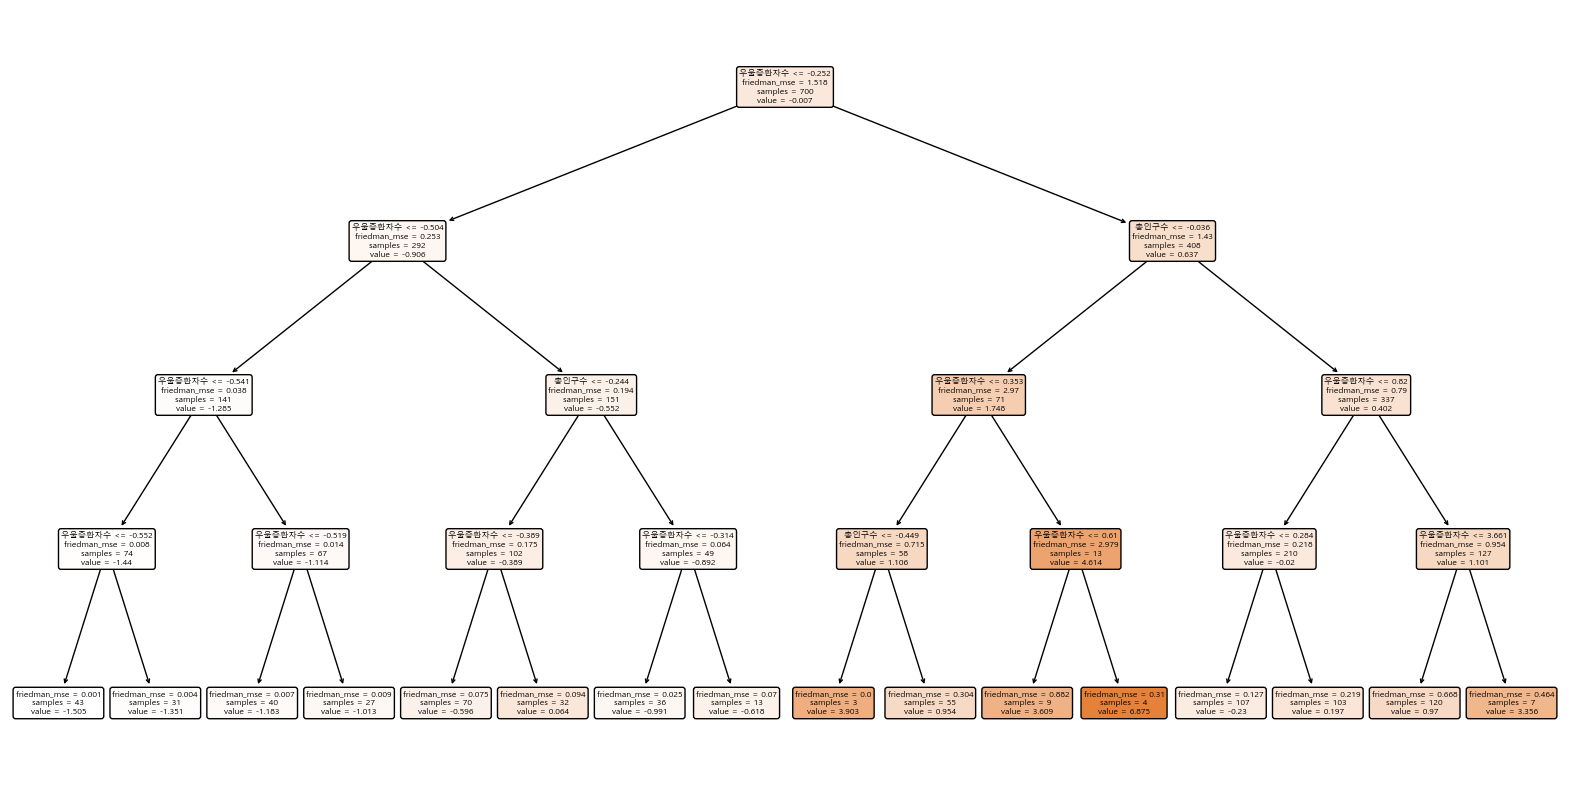

In [18]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 첫 번째 결정 트리를 추출
first_tree = gb_model.estimators_[0, 0]

# 결정 트리 시각화 및 이미지로 저장
plt.figure(figsize=(20, 10))
plot_tree(first_tree, filled=True, feature_names=list(X.columns), rounded=True, proportion=False)
plt.savefig('decision_tree_visualization.png', format='png', dpi=300, bbox_inches='tight')  # 이미지 저장
plt.show()

